In [7]:
import os
import numpy as np
from tqdm.notebook import tqdm
import guitarpro
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

from src.models.rnn import MusicRNN
from src.parse_gp import get_notes_and_durations
from src.save_midi import save_notes_and_durations

Изначально было интересно проверить возможность генерации барабанных дорожек в своем стиле. Поэтому в коде отражены особенности написания барабанных партий именно мной.

А именно: простой бит в 4/4 |36 38 36 38| (36 - бочка, 38 - рабочий) можно описать 4-я нотами и 4-я длительностями в 1/4. 

Я же написал бы тот же такт таким образом: |36 R R R 38 R R R 36 R R R 38 R R R|, где R - просто пауза и все длительности 1/16. Поэтому после парсинга ударных в списке нот до 40% пауз, которые могли усложнить модель (по факту нет).

Поэтому по мере роста гипотез добавились функции дропа этих пауз и парсинга оригинальных длительностей, так что теперь можно применять код для парсинга любой дорожки и использовать модель с конкатенацией как нот, так и длительностей.

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        tab_notes, tab_durations = get_notes_and_durations(tab, track_name, False)
        notes += tab_notes
        durations += tab_durations

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

<BarContainer object of 526 artists>

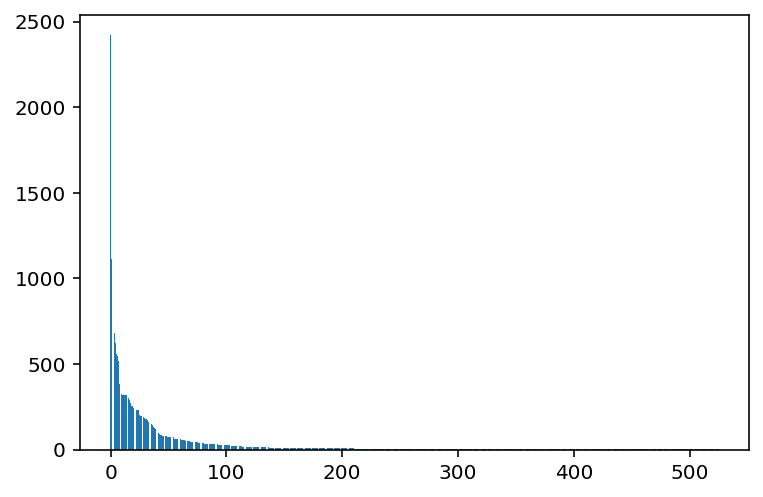

In [8]:
note_counts = Counter(notes)
df = pd.DataFrame(note_counts.items(), columns=['note', 'cnt']).sort_values('cnt', ascending=False)
plt.bar(range(df.shape[0]), df.cnt)

In [9]:
limit = 150
note_to_use = df.iloc[:limit].note.values

In [10]:
notes_corr, durations_corr = [], []
for note, dur in zip(notes, durations):
    if note in note_to_use:
        notes_corr.append(note)
        durations_corr.append(dur)

In [11]:
note_dictionary = {note: i for i, note in enumerate(note_to_use)}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes_corr]
notes_to_int[:10]

[22, 3, 3, 0, 3, 3, 3, 5, 3, 0]

In [12]:
duration_dictionary = {dur: i for i, dur in enumerate(set(durations_corr))}
inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
durations_to_int = [duration_dictionary[dur] for dur in durations_corr]
durations_to_int[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
n_notes = len(note_dictionary)
n_durations = len(duration_dictionary)
emb_size = 100
n_units = 128
n_layers = 2
use_dropout = True
use_attention = True

In [14]:
RNN = MusicRNN(
    n_notes,
    n_durations,
    emb_size,
    n_units,
    n_layers,
    use_dropout,
    use_attention,
)

In [15]:
RNN.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    15000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    3400        input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
seq_length = 32
step = 1
X, y = RNN.prepare_sequences(notes_to_int, durations_to_int, seq_length, step)

In [17]:
RNN.model.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/30
464/464 [==============================] - 16s 29ms/step - loss: 5.4576 - dense_1_loss: 4.0876 - dense_2_loss: 1.3700 - val_loss: 5.7662 - val_dense_1_loss: 4.3763 - val_dense_2_loss: 1.3899
Epoch 2/30
464/464 [==============================] - 13s 28ms/step - loss: 4.3786 - dense_1_loss: 3.3186 - dense_2_loss: 1.0600 - val_loss: 5.4618 - val_dense_1_loss: 4.1794 - val_dense_2_loss: 1.2824
Epoch 3/30
464/464 [==============================] - 13s 28ms/step - loss: 3.9746 - dense_1_loss: 2.9799 - dense_2_loss: 0.9947 - val_loss: 5.4323 - val_dense_1_loss: 4.1499 - val_dense_2_loss: 1.2824
Epoch 4/30
464/464 [==============================] - 13s 28ms/step - loss: 3.7476 - dense_1_loss: 2.7890 - dense_2_loss: 0.9586 - val_loss: 5.5372 - val_dense_1_loss: 4.2326 - val_dense_2_loss: 1.3046
Epoch 5/30
464/464 [==============================] - 13s 28ms/step - loss: 3.5980 - dense_1_loss: 2.6716 - dense_2_loss: 0.9264 - val_loss: 5.4955 - val_dense_1_loss: 4.1795 - val_dense_2_los

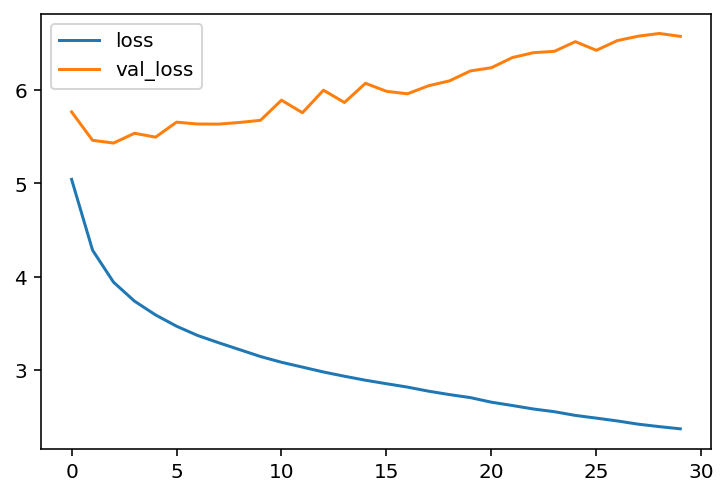

In [18]:
plt.figure()
plt.plot(RNN.model.history.history['loss'], label='loss')
plt.plot(RNN.model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [19]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [23]:
temperatures = [0.0, 0.5, 0.9]
n_generated = 100

# att_matrix = np.zeros((n_generated+seq_length, n_generated))

for temperature in temperatures:
    generated = [notes_to_int[:32], durations_to_int[:32]]
    for i in tqdm(range(n_generated)):
        note_pred, duration_pred = RNN.model.predict([np.array(generated[0][i:]), np.array(generated[1][i:])])
        generated[0].append(sample(note_pred[0], temperature))
        generated[1].append(sample(duration_pred[0], temperature))
    #     if use_attention:
    #         att_preds = RNN.att_model.predict(generated[i:])[0]
    #         att_matrix[(i-len(att_preds)+seq_length):(i+seq_length), i] = att_preds
    
    generated = [[inv_note_dictionary[x] for x in generated[0]], [inv_dur_dictionary[x] for x in generated[1]]]
    save_notes_and_durations(generated, f'output/rnn/output_{temperature}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
# if use_attention:
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = ax.imshow(att_matrix[(seq_length-2):,], cmap='coolwarm', interpolation='nearest')
#     ax.set_xticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.set_yticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
#     ax.set_xticks(np.arange(len(generated_to_notes) - seq_length))
#     ax.set_yticks(np.arange(len(generated_to_notes)- seq_length+2))
#     ax.set_xticklabels([n for n in generated_to_notes[(seq_length):]])
#     ax.set_yticklabels([n for n in generated_to_notes[(seq_length - 2):]])
#     ax.xaxis.tick_top()    
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
#              rotation_mode="anchor")

#     plt.show()